<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/Felix_Exploration_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Felix's Notebook #2 for exploring the assignment

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm
import math
import string
import cv2

In [3]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Hyper-parameters


In [26]:
# Hyper-parameters
NUM_EPOCHS = 50
BATCH_SIZE = 64
NUM_CHANNELS = 1
NUM_CLASSES = 36
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
FLATTEN_IMG_SIZE = 3136
TRAIN_TEST_SPLIT = 0.30
PRODUCTION = False
LABELLING = False
USE_UL = True

## The Convolutional Neural Network

Using AlexNet model adaptation as out network architecture.

[reference](https://pytorch.org/hub/pytorch_vision_alexnet/)



In [6]:
# visualize how the AlexNet model is built
# alex_net_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
# alex_net_model

In [7]:
class AlexNet_CNN(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super().__init__() # invoke the parent constructor
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2), # (b_sz, 1, 56, 56) --> (b_sz, 16, 56, 56)
            nn.MaxPool2d(2), # (b_sz, 32, 56, 56) --> (b_sz, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (b_sz, 32, 28, 28) --> (b_sz, 64, 28, 28)
            nn.MaxPool2d(2), # (b_sz, 64, 28, 28) --> (b_sz, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (b_sz, 64, 14, 14) --> (b_sz, 128, 14, 14)
            #nn.MaxPool2d(2), # (b_sz, 128, 14, 14) --> (b_sz, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 84, kernel_size=3, padding=1), # (b_sz, 128, 14, 14) --> (b_sz, 84, 14, 14)
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, padding=1), # (b_sz, 84, 14, 14) --> (b_sz, 84, 14, 14),
            nn.BatchNorm2d(84),
            nn.ReLU()
        )
        self.maxpool = nn.AdaptiveMaxPool2d(output_size=(6, 6))
        self.dense_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(84*6*6, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1512, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Linear(1512, self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.dense_block(x)
        return x

## Load and Show Data

In [8]:
FELIX_PATH = '/content/drive/MyDrive/P3-COMP551-FALL2021/'
TONY_PATH = '/content/drive/MyDrive/McGill/COMP551/data/'

def load_data(filename, data_path=FELIX_PATH):
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl
    

In [9]:
# Load data
# make sure to add a dimension to loaded pickles to respect dimensions required by Conv2D layers
train_l = load_data("images_l.pkl")[:, None]
# train_ul = load_data("images_ul.pkl")[:, None]
train_labels_l = load_data("labels_l.pkl")
test_ul = load_data("images_test.pkl")[:, None]

# Tony's new pkl files
train_ul = load_data("unlabelled_img.pkl")[:, None]
train_labels_ul = load_data("unlabelled_labels.pkl")

print("Train:", train_l.shape)
# print("Train UL:", train_ul.shape)
print("Train labels:", train_labels_l.shape)
print("Test:", test_ul.shape)

print("Train UL:", train_ul.shape)
print("Train UL labels:", train_labels_ul.shape)

Train: (30000, 1, 56, 56)
Train labels: (30000, 36)
Test: (15000, 1, 56, 56)
Train UL: (16684, 1, 56, 56)
Train UL labels: (16684, 36)


##Data Augmentation

In [10]:
# from scipy.ndimage import rotate

# from matplotlib import pyplot as plt

# angles = [90] # [90, 180, 270]
# # plt.imshow(train_l[0][0], interpolation='nearest')
# # plt.show()

# train_l_tmp = train_l[:].squeeze()
# train_labels_l_tmp = train_labels_l[:]

# for idx, img in tqdm(enumerate(train_l_tmp)):
#     for a in angles:
#         rotated = rotate(img, angle=a)
#         train_l_tmp = np.append(train_l_tmp, [rotated], axis=0)
#         train_labels_l_tmp = np.append(train_labels_l_tmp, [train_labels_l[idx]], axis=0)


# train_l = train_l_tmp[:, None]
# train_labels_l = train_labels_l_tmp
# print("Training augmented:", train_l.shape)
# print("Labels augmented:", train_labels_l.shape)

In [11]:
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
# Visualize some data
# alpha_dict = dict(enumerate(string.ascii_lowercase))
# figure = plt.figure(figsize=(20, 8))
# cols, rows = 20, 5
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_l), size=(1,)).item()
#     img = train_l[sample_idx]
#     label = get_label_value(train_labels_l[sample_idx])
#     figure.add_subplot(rows, cols, i)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img.squeeze())
# plt.show()

In [14]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class CustomDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, transform_target=None):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float() if targets is not None else None
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        x = self.data[index]

        # Apply median-filtering to remove salt-pepper noise
        # tmp = x.cpu().detach().numpy()
        # tmp = np.squeeze(tmp, axis=0)
        # img = Image.fromarray((tmp).astype(np.uint8))
        # result = cv2.medianBlur(np.array(img), 1)
        # x = torch.from_numpy(result).float().to(device)
        # x = x.unsqueeze(0)

        y = np.zeros(36, dtype=float)

        if self.targets is not None:
            y = self.targets[index]
        else:
            None
        if self.transform:
            x = self.transform(x)
        if self.transform_target:
            y = self.transform_target(y)
        
        return x, y
    
    
    def __len__(self):
        return len(self.data)

In [15]:
# LABELLED AND UNLABELLED DATA
# Tensor, Transform, Datasets, Dataloaders

# Split into training and validation
split_index_l = math.floor(len(train_labels_l)*TRAIN_TEST_SPLIT)
split_index_l_ul = math.floor((len(train_labels_l)+len(train_ul))*TRAIN_TEST_SPLIT)


full_train_l = train_l
train_l_ul = np.concatenate((full_train_l, train_ul))
full_train_l_ul = train_l_ul

val_l_ul = train_l_ul[:split_index_l_ul]
val_l = train_l[:split_index_l]
train_l = train_l[split_index_l:]
train_l_ul = train_l_ul[split_index_l_ul:]

full_train_labels_l = train_labels_l
train_labels_l_ul = np.concatenate((full_train_labels_l, train_labels_ul))
full_train_labels_l_ul = train_labels_l_ul

val_labels_l_ul = train_labels_l_ul[:split_index_l_ul]
val_labels_l = train_labels_l[:split_index_l]
train_labels_l = train_labels_l[split_index_l:]
train_labels_l_ul = train_labels_l_ul[split_index_l_ul:]

print("Full training:", full_train_l.shape, full_train_labels_l.shape)
print("Full training labeled and unlabeled:", full_train_l_ul.shape, full_train_labels_l_ul.shape)
print("Split Training:", train_l.shape, train_labels_l.shape)
print("Validation:", val_l.shape, val_labels_l.shape)

Full training: (30000, 1, 56, 56) (30000, 36)
Full training labeled and unlabeled: (46684, 1, 56, 56) (46684, 36)
Split Training: (21000, 1, 56, 56) (21000, 36)
Validation: (9000, 1, 56, 56) (9000, 36)


In [16]:
# LABELLED AND UNLABELLED DATA
# Turn data and labels into Datasets then DataLoaders

# Transform function
mean = (0.5,)
std = (0.5,)
transform = transforms.Compose(
    [transforms.Normalize(mean=mean, std=std)
     ])

# DataLoaders
full_train_l_dataloader = DataLoader(CustomDataset(full_train_l, full_train_labels_l, transform=None), shuffle=True, batch_size=BATCH_SIZE)
full_train_l_ul_dataloader = DataLoader(CustomDataset(full_train_l_ul, full_train_labels_l_ul, transform=None), shuffle=True, batch_size=BATCH_SIZE)
train_l_dataloader = DataLoader(CustomDataset(train_l, train_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)
train_l_ul_dataloader = DataLoader(CustomDataset(train_l_ul, train_labels_l_ul, transform=None), shuffle=True, batch_size=BATCH_SIZE)
val_l_dataloader = DataLoader(CustomDataset(val_l, val_labels_l, transform=None), shuffle=False)
val_l_ul_dataloader = DataLoader(CustomDataset(val_l_ul, val_labels_l_ul, transform=None), shuffle=False)

# Raw unlabeled dataset
# train_ul_labels = np.zeros(shape=(len(train_ul), 36))
# train_ul_dataloader = DataLoader(CustomDataset(train_ul, train_ul_labels, transform=None), batch_size=BATCH_SIZE, shuffle=False)

# Test set for Kaggle
test_labels_ul = np.zeros(shape=(len(test_ul), 36))
test_ul_dataloader = DataLoader(CustomDataset(test_ul, test_labels_ul, transform=None), batch_size=BATCH_SIZE, shuffle=False)


# print("Training Augmented:", BATCH_SIZE*len(iter(train_l_dataloader)))


In [17]:
# ONLY LABELLED DATA

# Tensor, Transform, Datasets, Dataloaders

# Split into training and validation
# split_index_l = math.floor(len(train_labels_l)*TRAIN_TEST_SPLIT)
# split_index_l_ul = math.floor((len(train_labels_l)+len(train_ul))*TRAIN_TEST_SPLIT)

# val_l = train_l[:split_index_l]
# train_l = train_l[split_index_l:]

# val_labels_l = train_labels_l[:split_index_l]
# train_labels_l = train_labels_l[split_index_l:]

# print("Split Training:", train_l.shape, train_labels_l.shape)
# print("Validation:", val_l.shape, val_labels_l.shape)

In [18]:
# ONLY LABELLED DATA
# Turn data and labels into Datasets then DataLoaders

# Transform function
# mean = (0.5,)
# std = (0.5,)
# transform = transforms.Compose(
#     [transforms.Resize(56),
#      transforms.Normalize(mean=mean, std=std)
#      ])

# # DataLoaders
# train_l_dataloader = DataLoader(CustomDataset(train_l, train_labels_l, transform=None), shuffle=True, batch_size=BATCH_SIZE)
# val_l_dataloader = DataLoader(CustomDataset(val_l, val_labels_l, transform=None), shuffle=False)

# # Raw unlabeled dataset
# train_ul_labels = np.zeros(shape=(len(train_ul), 36))
# train_ul_dataloader = DataLoader(CustomDataset(train_ul, train_ul_labels, transform=None), batch_size=BATCH_SIZE, shuffle=False)

# # Test set for Kaggle
# test_labels_ul = np.zeros(shape=(len(test_ul), 36))
# test_ul_dataloader = DataLoader(CustomDataset(test_ul, test_labels_ul, transform=None), batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


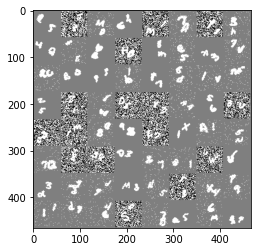

In [19]:
imgs, labels = next(iter(full_train_l_dataloader))

imshow(torchvision.utils.make_grid(imgs.cpu()))


## Initialize

## Train

In [20]:
def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()

    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0

        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]

        return_array.append(new_numbers + new_letters)

    return return_array

In [21]:
# Train function
def train(model, dataloader=train_l_dataloader, init_rounds=2):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        

        # Using unlabeled data
        # if epoch >= init_rounds:
        #     for idx, data_ul in enumerate(train_ul_dataloader):
        #         # get data/targets
        #         inputs_ul, targets_ul = data_ul
        #         inputs_ul = inputs_ul.to(device)
        #         outputs = model(inputs_ul)
        #         fake_targets = torch.Tensor(convert_outputs_to_preds(outputs.cpu().detach().numpy())).to(device) # using pseudo label methods and get pseudo labels
        #         # print(fake_targets[0])
        #         optimizer.zero_grad()
        #         outputs = model(inputs_ul)
        #         loss = criterion(outputs, fake_targets)
        #         loss.backward()
        #         # optimizer.step()


        for i, data in enumerate(dataloader):
            # get data/targets
            inputs, true_targets = data
            inputs = inputs.to(device)
            true_targets = true_targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward, backward,
            outputs = model(inputs)
            loss = criterion(outputs, true_targets)

            # backward
            loss.backward()

            # gradient descent step
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # track learning
            running_loss += loss.item()
            acc, acc_d, acc_l = eval_model(model, dataloader)
            if i % 100 == 99:    # print every 2000 mini-batches
                # print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                print('[epoch %d] loss: %.3f, acc: %.3f, digit_acc: %.3f, letter_acc: %.3f'%(epoch+1, running_loss/i, acc, acc_d, acc_l))
                running_loss = 0.0
    
    # DONE TRAINING
    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)

## Test

In [22]:
# Methods to calculate some accuracy metrics
def convert_outputs_to_preds(outputs):
    preds = np.empty(shape=(len(outputs), 36))
    for i, output in enumerate(outputs):
        pred = np.zeros(36)
        digit_index = np.argmax(output[:11])
        letter_index = np.argmax(output[11:]) + 11
        pred[digit_index], pred[letter_index] = 1, 1
        preds[i] = pred
    return preds
    
def correct_digits(preds, labels):
    return np.map((preds, labek))

def correct_letters(preds, labels):
    return np.array_equal(pred[11:],label[11:])

def get_accuracy(preds, labels):
    preds_str = convert_labels_to_strings(preds)
    labels_str = convert_labels_to_strings(labels)
    correct_preds = np.equal(preds_str, labels_str)
    return correct_preds.sum() / len(labels)

def check_prediction(preds, labels):
    return np.equal(preds, labels)

def print_model_weights(model):
    for name, param in model.named_parameters():
      print(name, param.size())    

def convert_labels_to_strings(labels):
  result = np.empty(len(labels)).astype('object')
  for i, pred in enumerate(labels):
    prediction = ''
    for elem in pred:
      prediction = prediction + str(int(elem))
    result[i] = prediction
  return result

In [23]:
# Evaluation function
def eval_model(model, dl):
    accs, accs_d, accs_l = [], [], []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = convert_outputs_to_preds(outputs.cpu().detach().numpy())
            preds_d = preds[:, :11]
            preds_l = preds[:, 11:]
            labels_d = labels[:, :11]
            labels_l = labels[:, 11:]
            accs.append(get_accuracy(preds, labels.cpu()))
            accs_d.append(get_accuracy(preds_d, labels_d.cpu()))
            accs_l.append(get_accuracy(preds_l, labels_l.cpu()))
            break
    return sum(accs)/len(accs), sum(accs_d)/len(accs_d), sum(accs_l)/len(accs_l)

In [27]:
# Run model and evaluate
cnn_model = AlexNet_CNN().to(device)
if USE_UL:
    trainloader = full_train_l_ul_dataloader if PRODUCTION else train_l_ul_dataloader
else: # use only the original labelled training set
    trainloader = full_train_l_dataloader if PRODUCTION else train_l_dataloader
train(cnn_model, trainloader)
if not PRODUCTION:
    eval_model(cnn_model, val_l_dataloader)

[epoch 1] loss: 0.494, acc: 0.000, digit_acc: 0.031, letter_acc: 0.031
[epoch 1] loss: 0.210, acc: 0.000, digit_acc: 0.078, letter_acc: 0.047
[epoch 1] loss: 0.136, acc: 0.016, digit_acc: 0.109, letter_acc: 0.125
[epoch 1] loss: 0.099, acc: 0.000, digit_acc: 0.234, letter_acc: 0.047
[epoch 1] loss: 0.074, acc: 0.031, digit_acc: 0.453, letter_acc: 0.156
[epoch 1] loss: 0.057, acc: 0.125, digit_acc: 0.453, letter_acc: 0.219
[epoch 1] loss: 0.042, acc: 0.203, digit_acc: 0.688, letter_acc: 0.281
[epoch 2] loss: 0.234, acc: 0.297, digit_acc: 0.812, letter_acc: 0.391
[epoch 2] loss: 0.093, acc: 0.516, digit_acc: 0.828, letter_acc: 0.594
[epoch 2] loss: 0.050, acc: 0.594, digit_acc: 0.812, letter_acc: 0.641
[epoch 2] loss: 0.032, acc: 0.781, digit_acc: 0.906, letter_acc: 0.844
[epoch 2] loss: 0.022, acc: 0.688, digit_acc: 0.859, letter_acc: 0.734
[epoch 2] loss: 0.016, acc: 0.750, digit_acc: 0.906, letter_acc: 0.812
[epoch 2] loss: 0.012, acc: 0.891, digit_acc: 0.938, letter_acc: 0.938
[epoch

In [28]:
if LABELLING:
    # Label the unlabelled dataset
    with torch.no_grad():
        predictions_ul = []
        for data in train_ul_dataloader:
            inputs = data[0].to(device)
            targets = data[1].to(device)
            outputs = cnn_model(inputs)
            converted_output = convert_outputs_to_preds(outputs.cpu().detach().numpy())
            for c in converted_output:
                predictions_ul.append(c)

    print(len(predictions_ul))
    predictions_ul = np.array(predictions_ul)
    print(type(predictions_ul))

    with open('labels_ul.pkl', 'wb') as train_labels_ul_pkl:
        pickle.dump(predictions_ul, train_labels_ul_pkl)

## Export To CSV

In [29]:
# Setup CSV for predictions export
if PRODUCTION:
    df = pd.DataFrame(columns=['# Id', 'Category'])
    with torch.no_grad():
        i = 0
        for data in test_ul_dataloader:
            inputs = data[0].to(device)
            targets = data[1].to(device)
            outputs = cnn_model(inputs) # apply CNN model
            predictions = transform_output(outputs)
            for pred in predictions:
                label = ''.join(str(x) for x in pred)
                df.loc[i] = [i, label]
                i += 1

In [30]:
df

,# Id,Category
0,0,000010000000000000000000000001000000
1,1,000010000000000000000100000000000000
2,2,000000000100000000010000000000000000
3,3,100000000000000000000100000000000000
4,4,000000100000000000010000000000000000
...,...,...
14995,14995,000100000000001000000000000000000000
14996,14996,000100000010000000000000000000000000
14997,14997,000000100000000000000000001000000000
14998,14998,010000000000000000100000000000000000


In [31]:
# Export CSV for Kaggle
from datetime import datetime
if PRODUCTION:
    filename = 'kaggle_g19_{}.csv'.format(datetime.now())
    df.to_csv(filename, sep=',', float_format='{:36}', index=False)

## Not Sure ?

In [ ]:
# # Implement CONV Net


# # # VGG11 Conv Net
# # class ConvNet_VGG11(nn.Module):
# #     def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
# #         super(ConvNet_VGG11, self).__init__()
# #         self.in_channels = in_channels
# #         self.num_classes = num_classes
# #         # convolution layers

# #         self.block1_conv1 = nn.Sequential(
# #             nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.MaxPool2d(kernel_size=2, stride=2)
# #         )

# #         self.block2_conv1 = nn.Sequential(
# #             nn.Conv2d(64, 128, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.MaxPool2d(kernel_size=2, stride=2)
# #         )

# #         self.block3_conv1 = nn.Sequential(
# #             nn.Conv2d(128, 256, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.Conv2d(256, 256, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.MaxPool2d(kernel_size=2, stride=2)
# #         )

# #         self.block4_conv1 = nn.Sequential(
# #             nn.Conv2d(256, 512, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.Conv2d(512, 512, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.MaxPool2d(kernel_size=2, stride=2)
# #         )

# #         self.block5_conv1 = nn.Sequential(
# #             nn.Conv2d(512, 512, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.Conv2d(512, 512, kernel_size=3, padding=1),
# #             nn.ReLU(),
# #             nn.MaxPool2d(kernel_size=2, stride=2)
# #         )

# #         self.linear_layers = nn.Sequential(
# #             nn.Linear(in_features=512, out_features=4096),
# #             nn.ReLU(),
# #             nn.Dropout2d(0.5),
# #             nn.Linear(in_features=4096, out_features=4096),
# #             nn.ReLU(),
# #             nn.Dropout2d(0.5),
# #             nn.Linear(in_features=4096, out_features=self.num_classes)
# #         )

# #     def forward(self, x):
# #         x = self.block1_conv1(x)
# #         x = self.block2_conv1(x)
# #         x = self.block3_conv1(x)
# #         x = self.block4_conv1(x)
# #         x = self.block5_conv1(x)
# #         # flatten to prepare for the fully connected layers
# #         x = x.view(x.size(0), -1)
# #         x = self.linear_layers(x)
# #         return x

# # ConvNet
# class ConvNet(nn.Module):
#     def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
#         super().__init__() 
#         self.in_channels = in_channels
#         self.num_classes = num_classes
#         self.conv_block1 = nn.Sequential(
#             nn.Conv2d(self.in_channels, 16, 3), # (b_sz, 1, 56, 56) --> (b_sz, 16, 54, 54)
#             nn.MaxPool2d(3), # (b_sz, 16, 54, 54) --> (b_sz, 16, 18, 18)
#             nn.ReLU()
#         )
#         self.conv_block2 = nn.Sequential(
#             nn.Conv2d(16, 32, 3), # (b_sz, 16, 18, 18) --> (b_sz, 32, 16, 16)
#             nn.MaxPool2d(2), # (b_sz, 32, 16, 16) --> (b_sz, 32, 8, 8)
#             nn.ReLU()
#         )
#         self.conv_block3 = nn.Sequential(
#             nn.Conv2d(32, 64, 3), # (b_sz, 32, 8, 8) --> (b_sz, 64, 6, 6)
#             nn.MaxPool2d(2), # (b_sz, 64, 6, 6) --> (b_sz, 64, 3, 3)
#             nn.ReLU()
#         )
#         self.linear_layers = nn.Sequential(
#             nn.Linear(64*3*3, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, self.num_classes), 
#         )
    
#     def forward(self, x):
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         x = self.conv_block3(x)
#         x = x.view(x.size()[0], -1)
#         x = self.linear_layers(x)
#         return x

# model = ConvNet().to(device)

In [ ]:
# Test model flow, check output size, shoudl be [batchs_size, num_classes]
# dummy_model = ConvNet()
# random_input = torch.rand(BATCH_SIZE, 1, 56, 56)
# print(random_input.shape)
# output = dummy_model(random_input)
# print(output.shape)

In [ ]:
# criterion = nn.BCEWithLogitsLoss()
# # optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# val_accuracies = []
# trainloader = full_train_l_dataloader if PRODUCTION else train_l_dataloader
# init_round = int(round(NUM_EPOCHS/2))
# print(trainloader)
# for epoch in range(NUM_EPOCHS):
#     running_loss = 0.0
#     model.train()
    
#     # Using unlabeled data
#     if epoch >= init_round:
#         for i, (data, targets) in enumerate(train_ul_dataloader):
#             # get data/targets
#             inputs = data
#             true_targets = targets
#             outputs = model(inputs)
#             print("Outputs unlabeled:", outputs.shape)
#             fake_targets = transform_output(outputs) # using pseudi label methos and get pseudo labels
#             fake_predictions = torch.Tensor().to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             print("Unlabeled:", outputs.shape)
#             loss = criterion(outputs, fake_predictions)
#             loss.backward()
#             optimizer.step()

#             # track learning
#             running_loss += loss.item()
#             if i % 100 == 99:    # print every 2000 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                     (epoch + 1, i + 1, running_loss / 100))
#                 running_loss = 0.0

#     for i, (data, targets) in enumerate(trainloader):
        
#         # get data/targets
#         inputs = data
#         true_targets = targets
#         # zero the parameter gradients
#         optimizer.zero_grad()
#         # forward, backward,
#         outputs = model(inputs)
#         print("Outputs labeled:", outputs.shape)
#         print("Labeled:", outputs.shape)
#         loss = criterion(outputs, true_targets)
#         # backward
#         loss.backward()
#         # gradient descent step
#         optimizer.step()

#         # track learning
#         running_loss += loss.item()
#         if i % 100 == 99:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0

#     if not PRODUCTION:
#         model.eval()
#         digit_results = []
#         letter_results = []
#         for i, data in enumerate(val_l_dataloader):
#             val_inputs, val_labels = data
#             outputs = model(val_inputs)
#             val_labels = val_labels.cpu().detach().numpy()
#             preds = convert_outputs_to_preds(outputs.cpu().detach().numpy())
#             digit_results.append(correct_digit(preds[0], val_labels[0]))
#             letter_results.append(correct_letter(preds[0], val_labels[0]))
#         digit_accuracy = get_accuracy(digit_results)
#         letter_accuracy = get_accuracy(letter_results)
#         total_accuracy = get_accuracy(digit_results and letter_results)
#         val_accuracies.append((digit_accuracy, letter_accuracy, total_accuracy))
        

# print('Finished Training')
# PATH = './cnn.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
# # Check validation accuracy
# if not PRODUCTION:
#     for i, val_accuracy in enumerate(val_accuracies):
#         print('Epoch = {}, Total Acc = {}, Digit Acc = {}, Letter Acc = {}'.format(i+1, val_accuracy[2], val_accuracy[0], val_accuracy[1]))

In [ ]:
# Run model using the labelled unlabelled data
# cnn_model = AlexNet_CNN().to(device)
# trainloader = full_train_l_ul_dataloader if PRODUCTION else train_l_ul_dataloader
# train(cnn_model, trainloader)
# if not PRODUCTION:
#     eval_model(cnn_model, val_l_ul_dataloader)